In [1]:
import os
from shutil import rmtree
from tempfile import mkdtemp

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_score, confusion_matrix,ConfusionMatrixDisplay, get_scorer
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count()-2)

In [3]:
df = pd.read_csv('../Dataset/dataFrameProcessed')
targetCol = 'imdb_rating'
X = df.drop(columns=[targetCol])
y = df[targetCol]
fold = 5

In [4]:
models = {
    'Support Vector Machine': SVC(kernel='rbf', random_state=42),
    'Random Forest'         : RandomForestClassifier(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=42),
}

In [5]:
scoringMetrics = {
    'accuracy'  : 'accuracy',
    'precision' : make_scorer(precision_score, average='weighted', zero_division=1),
    'recall'    : 'recall_weighted',
    'f1'        : 'f1_weighted'
}

In [6]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

In [ ]:
for name, model in models.items():
    print(f'{name}')

    model.fit(XTrain, yTrain)

    for metricName, scorer in scoringMetrics.items():
        if isinstance(scorer, str):
            scorer = get_scorer(scorer)

        score = scorer(model, XTest, yTest)
        print(f"  {metricName:<10}: {score:.5f}")

    yPred = model.predict(XTest)
    confusionMatrix = confusion_matrix(yTest, yPred)
    display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=model.classes_)

    fig, axes = plt.subplots(figsize=(6, 6))
    display.plot(cmap='gist_gray', ax=axes, values_format='d')
    plt.title(f'{name}')
    plt.show()

    print("\n")

In [ ]:
dataset_results = []

for model_name, model in models.items():
    print(f'Running {model_name}...')

    clf = Pipeline(steps=[
        ('feature_selection', SelectFromModel(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            threshold='median')
         ),
        ('classifier', model)
    ])

    try:
        cvResult = cross_validate(
            clf,
            X,
            y,
            cv= fold,
            scoring=scoringMetrics,
            n_jobs=-1,
            error_score='raise'
        )

        dataset_results.append({
            'Model'     : model_name,
            'Accuracy'  : np.mean(cvResult['test_accuracy']),
            'Precision' : np.mean(cvResult['test_precision']),
            'Recall'    : np.mean(cvResult['test_recall']),
            'F1 Score'  : np.mean(cvResult['test_f1'])
        })

    except Exception as e:
        print(f'Failed to run {model_name}. Error: {e}')

if dataset_results:
    results_df = pd.DataFrame(dataset_results).set_index('Model')
    results_df = results_df.sort_values(by="F1 Score", ascending=False)

    print('\nPerformance:\n')
    print(results_df)
else:
    print('No models ran successfully.')

Fitting 2 folds for each of 32 candidates, totalling 64 fits
  accuracy  : 0.81200
  precision : 0.81446
  recall    : 0.81200
  f1        : 0.81166


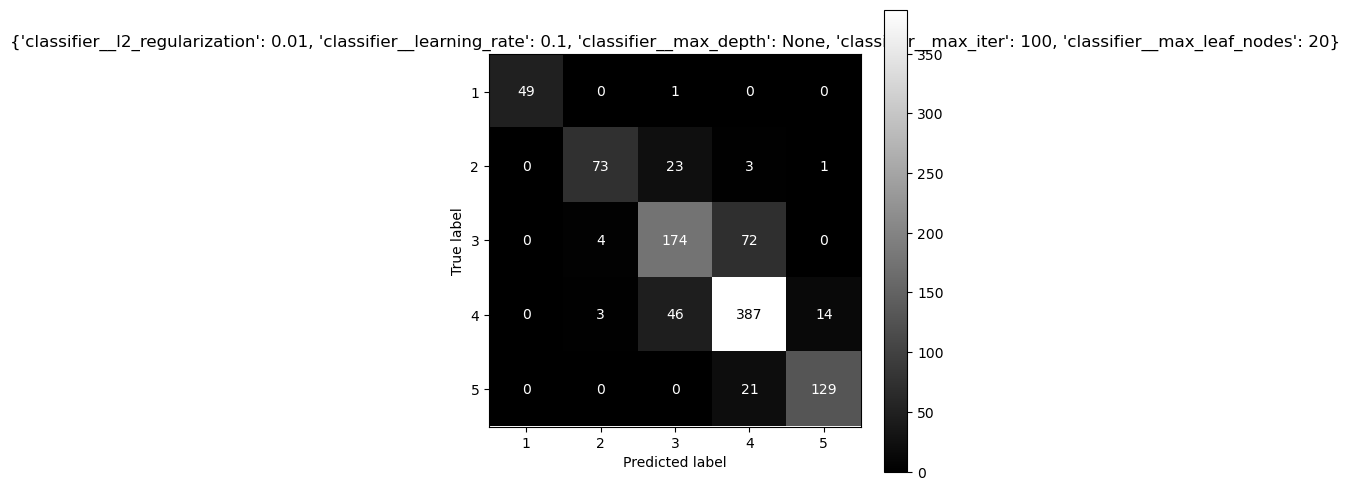

In [7]:
cachedir = mkdtemp()

# 2. Add 'memory' to the pipeline
pipeline = Pipeline(steps=[
    ('feature_selection', SelectFromModel(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1),
        threshold='median')
    ),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
], memory=cachedir)

param_grid = {
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__max_iter': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__l2_regularization': [0, 0.01],
    'classifier__max_leaf_nodes': [10,20]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=2,
    n_jobs=-1,
    verbose=3
)

grid_search.fit(XTrain, yTrain)

for metricName, scorer in scoringMetrics.items():
    if isinstance(scorer, str):
        scorer = get_scorer(scorer)

    score = scorer(grid_search, XTest, yTest)
    print(f"  {metricName:<10}: {score:.5f}")

yPred = grid_search.predict(XTest)
confusionMatrix = confusion_matrix(yTest, yPred)
display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=grid_search.classes_)

fig, axes = plt.subplots(figsize=(6, 6))
display.plot(cmap='gist_gray', ax=axes, values_format='d')
plt.title(f'{grid_search.best_params_}')
plt.show()

rmtree(cachedir)